# Select games for analysis

In [1]:
# standard lib
import sqlite3
import io
import time

# data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# utils
from tqdm.notebook import tqdm

In [2]:
con = sqlite3.connect('/Volumes/Extreme SSD/chessdata/data_smaller_1pct.db')
cur = con.cursor()

In [3]:
events = ["Rated Bullet game", "Rated Blitz game", "Rated Rapid game", "Rated Classical game"]
time_control = ["60+0", "300+0", "600+0", "1800+0"]

## Look at how many of each category we got

In [5]:
query = "SELECT COUNT(*) FROM games;"
res = cur.execute(query)
print(res.fetchone())

(6181416,)


In [6]:
for e, t in zip(events, time_control):
    query = f"SELECT COUNT(*) FROM games WHERE Event = '{e}';"
    res = cur.execute(query)
    print(f"{e}s", res.fetchone())
    query = f"SELECT COUNT(*) FROM games WHERE TimeControl = '{t}';"
    res = cur.execute(query)
    print(f"{t}", res.fetchone())

Rated Blitz games (1603068,)
60+0 (3335966,)
Rated Bullet games (3335966,)
300+0 (1603068,)
Rated Rapid games (1199202,)
600+0 (1199202,)
Rated Classical games (43180,)
1800+0 (43180,)


# Filter each type of game

## Import data and transform dtypes

In [31]:
# num = 0 # ["Rated Bullet game", "Rated Blitz game", "Rated Rapid game", "Rated Classical game"]
# query = f"SELECT * FROM games WHERE TimeControl = '{time_control[num]}'"
query = f"SELECT Event, WhiteElo, BlackElo, TimeControl, ECO, Opening, Termination FROM games"
df = pd.read_sql_query(query, con)

In [32]:
df.count()

Event          6181416
WhiteElo       6181416
BlackElo       6181416
TimeControl    6181416
ECO            6181416
Opening        6181416
Termination    6181416
dtype: int64

In [33]:
# Replace ? with NaN
# But there don't seem to be any ? in this dataset
df = df.replace(to_replace="?", value=np.nan)

In [34]:
# there are no missing values in these columns
df.count()

Event          6181416
WhiteElo       6181416
BlackElo       6181416
TimeControl    6181416
ECO            6181416
Opening        6181416
Termination    6181416
dtype: int64

In [35]:
# See the dtypes. Might want to convert some of these to more useful things.
df.dtypes

Event          object
WhiteElo        int64
BlackElo        int64
TimeControl    object
ECO            object
Opening        object
Termination    object
dtype: object

In [36]:
# See the memory usage, out of curiosity
df.memory_usage()/10**6

Index           0.000128
Event          49.451328
WhiteElo       49.451328
BlackElo       49.451328
TimeControl    49.451328
ECO            49.451328
Opening        49.451328
Termination    49.451328
dtype: float64

In [38]:
# Top 20 ECO values
df["ECO"].value_counts().head(20)

ECO
A00    437725
A40    394851
B01    363901
B00    304492
C00    274008
D00    273088
C20    170952
C50    161697
B10    156453
B06    147927
C41    141309
D02    135820
C44    127850
A01    126879
B20    105509
C40     99300
A04     89160
A45     85746
C23     81508
A43     76754
Name: count, dtype: int64

In [40]:
# Top 20 Opening values
df["Opening"].value_counts().head(20)

Opening
Queen's Pawn Game                                182352
Van't Kruijs Opening                             127070
Caro-Kann Defense                                117937
Modern Defense                                   116256
Philidor Defense                                 109452
Scandinavian Defense                             101782
Scandinavian Defense: Mieses-Kotroc Variation     93849
Queen's Pawn Game: Accelerated London System      92822
Pirc Defense                                      92775
Horwitz Defense                                   90644
French Defense: Knight Variation                  90272
Owen Defense                                      81598
Hungarian Opening                                 68613
Scandinavian Defense: Valencian Variation         63418
Queen's Pawn Game: Modern Defense                 63393
Bishop's Opening                                  59042
Benoni Defense: Old Benoni                        58457
Indian Defense                          

In [41]:
# Termination values
df["Termination"].value_counts()

Termination
Normal              3806978
Time forfeit        2372795
Abandoned              1483
Rules infraction        160
Name: count, dtype: int64

In [53]:
1483+160

1643

In [42]:
# Termination values broken down by game type
df.groupby("Event")["Termination"].value_counts()

Event                 Termination     
Rated Blitz game      Normal              1254605
                      Time forfeit         348002
                      Abandoned               428
                      Rules infraction         33
Rated Bullet game     Time forfeit        1879403
                      Normal              1455928
                      Abandoned               628
                      Rules infraction          7
Rated Classical game  Normal                39568
                      Time forfeit           3577
                      Abandoned                25
                      Rules infraction         10
Rated Rapid game      Normal              1056877
                      Time forfeit         141813
                      Abandoned               402
                      Rules infraction        110
Name: count, dtype: int64

In [47]:
# drop ECO and Opening columns because we don't need them for this analysis
df.drop(columns=["ECO", "Opening"], inplace=True)

In [51]:
# Filter out the Abandoned and Rules infraction games
df = df[(df["Termination"]!="Rules infraction")&(df["Termination"]!="Abandoned")]

In [54]:
df.shape

(6179773, 5)

In [52]:
df["Event"].value_counts()

Event
Rated Bullet game       3335331
Rated Blitz game        1602607
Rated Rapid game        1198690
Rated Classical game      43145
Name: count, dtype: int64

# Get dataset sorted by game urls (Site)

In [4]:
# https://stackoverflow.com/questions/18613055/is-order-by-and-row-number-deterministic
# want to get unique sorting
# seems to be unique when you combine UTCDateTime, WhiteElo, and BlackElo
# query = """SELECT Event, WhiteElo, BlackElo, UTCDateTime, Termination FROM games 
#     WHERE (Termination == 'Normal' OR Termination == 'Time forfeit') 
#     ORDER BY UTCDateTime, WhiteElo, BlackElo"""
query = """SELECT Event, Site, WhiteElo, BlackElo, UTCDateTime, Termination FROM games 
    WHERE (Termination == 'Normal' OR Termination == 'Time forfeit') 
    ORDER BY Site"""
df = pd.read_sql_query(query, con)

In [5]:
df["Event"].value_counts()

Event
Rated Bullet game       3335331
Rated Blitz game        1602607
Rated Rapid game        1198690
Rated Classical game      43145
Name: count, dtype: int64

In [6]:
df.shape

(6179773, 6)

In [7]:
(df["UTCDateTime"]+df["WhiteElo"].astype(str)+df["BlackElo"].astype(str)).unique().shape

(6179773,)

In [8]:
df["Site"].unique().shape

(6179773,)

In [9]:
df["Site"].head()

0    https://lichess.org/0000Vlow
1    https://lichess.org/0000fjWS
2    https://lichess.org/0001epJ5
3    https://lichess.org/00033ntZ
4    https://lichess.org/00038fpL
Name: Site, dtype: object

In [11]:
df["UTCDateTime"].head()

0    2024-03-09 12:32:05
1    2024-05-31 22:26:27
2    2024-05-08 08:46:25
3    2024-11-17 10:41:58
4    2024-03-06 19:48:52
Name: UTCDateTime, dtype: object

In [10]:
query = """CREATE INDEX IF NOT EXISTS site_index ON games (Site)"""
cur.execute(query)

# Select data by Elo 
I'm thinking of dividing the Elo into bins and going for an even distribution across bins. Basically group by Elo bin and select random games from each group.
## First plot the Elo distribution

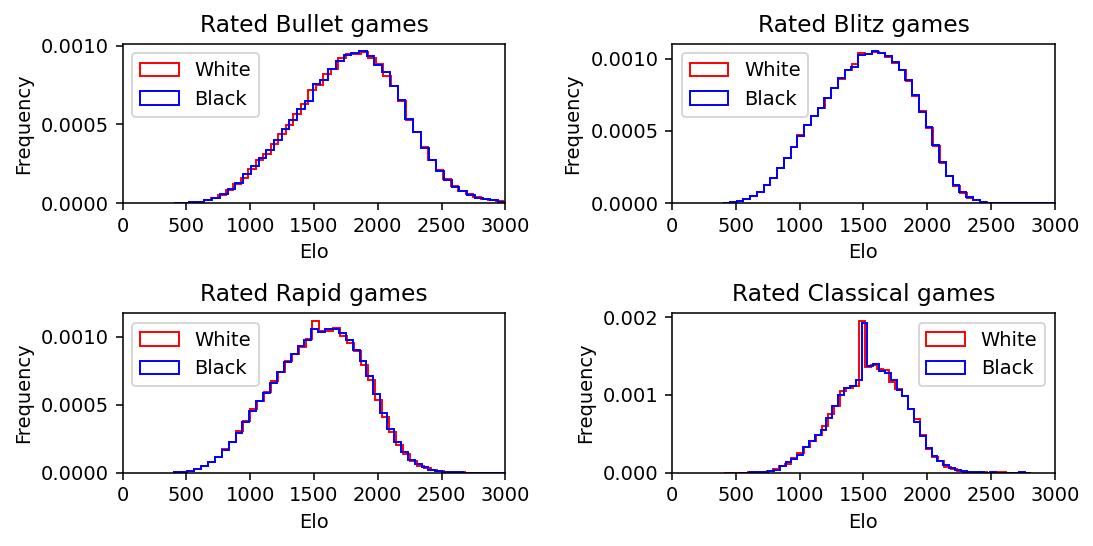

In [12]:
fig, axes = plt.subplots(2,2, figsize=(8,4), dpi=140)
for i, ax in enumerate(axes.flatten()):
    df[df["Event"] == events[i]]["WhiteElo"].plot.hist(ax=ax, bins=50, histtype="step", color="red", label="White", density=True)
    df[df["Event"] == events[i]]["BlackElo"].plot.hist(ax=ax, bins=50, histtype="step", color="blue", label="Black", density=True)
    ax.set_title(f"{events[i]}s")
    ax.set_xlabel("Elo")
    ax.set_xlim(0,3000)
    ax.legend()
fig.tight_layout()

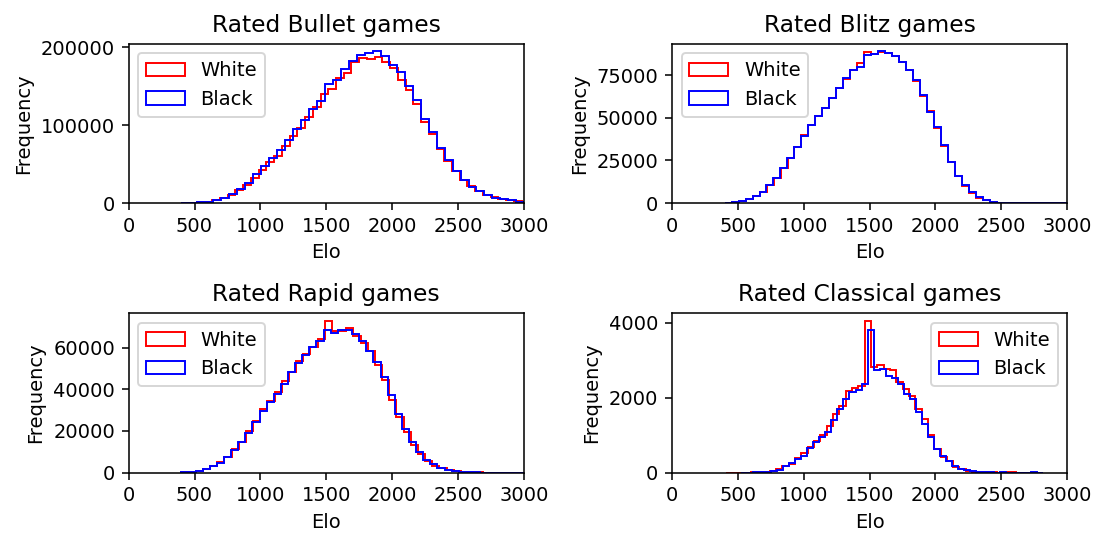

In [13]:
fig, axes = plt.subplots(2,2, figsize=(8,4), dpi=140)
for i, ax in enumerate(axes.flatten()):
    df[df["Event"] == events[i]]["WhiteElo"].plot.hist(ax=ax, bins=50, histtype="step", color="red", label="White")
    df[df["Event"] == events[i]]["BlackElo"].plot.hist(ax=ax, bins=50, histtype="step", color="blue", label="Black")
    ax.set_title(f"{events[i]}s")
    ax.set_xlabel("Elo")
    ax.set_xlim(0,3000)
    ax.legend()
fig.tight_layout()

Resampling strategy:
- Cut off the tails (perhaps keeping the 99.9% interval in the middle) of both White and Black Elo
- Bin into N bins (try e.g. 40 bins)
- Select randomly a number of games from that bin so as to get ~25,000 games total for each category
- Check resulting distributions of Elo

In [14]:
event_dfs = []
for e in events:
    edf = df[df["Event"] == e]
    # get the 95% in the middle for both White and Black
    for player in ["White", "Black"]:
        # middle95 = pd.qcut(edf[f"{player}Elo"], q=[0, 0.05, .95, 1], labels=["Bottom", "Middle", "Top"])
        middle99 = pd.qcut(edf[f"{player}Elo"], q=[0, 0.001, .999, 1], labels=["Bottom", "Middle", "Top"])
        edf = edf[middle99 == "Middle"]
    event_dfs.append(edf)

In [15]:
event_dfs[0].describe()

,WhiteElo,BlackElo
count,3.322002e+06,3.322002e+06
mean,1.775800e+03,1.775833e+03
std,4.013363e+02,4.011693e+02
min,6.400000e+02,6.760000e+02
25%,1.499000e+03,1.499000e+03
50%,1.792000e+03,1.792000e+03
75%,2.061000e+03,2.061000e+03
max,2.947000e+03,2.909000e+03


In [16]:
event_dfs[1].describe()

,WhiteElo,BlackElo
count,1.596228e+06,1.596228e+06
mean,1.518440e+03,1.518558e+03
std,3.479638e+02,3.478552e+02
min,5.480000e+02,5.720000e+02
25%,1.269000e+03,1.269000e+03
50%,1.535000e+03,1.536000e+03
75%,1.780000e+03,1.780000e+03
max,2.395000e+03,2.377000e+03


In [17]:
event_dfs[0].shape, event_dfs[1].shape, event_dfs[2].shape

((3322002, 6), (1596228, 6), (1193891, 6))

In [18]:
# bin into N bins
bins = 30
desired_sizes = [33334, 33333, 33333]
# how many should we sample from each bin to get the desired size? desired_size/bins
print(desired_sizes[0]/bins)
resampled_dfs = []
player = "Black"
for i, edf in enumerate(event_dfs[:3]):
    print(events[i])
    edf[f"{player}EloBins"] = pd.cut(edf[f"{player}Elo"], bins=bins)
    smaller_edf = edf.groupby(f"{player}EloBins", as_index=False).sample(n=int(desired_sizes[i]/bins)+1, replace=False)
    resampled_dfs.append(smaller_edf)

1111.1333333333334
Rated Bullet game


/var/folders/ns/cpwqr00s7y55npv2jxl63gm80000gn/T/ipykernel_39765/2192498540.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  smaller_edf = edf.groupby(f"{player}EloBins", as_index=False).sample(n=int(desired_sizes[i]/bins)+1, replace=False)


Rated Blitz game


/var/folders/ns/cpwqr00s7y55npv2jxl63gm80000gn/T/ipykernel_39765/2192498540.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  smaller_edf = edf.groupby(f"{player}EloBins", as_index=False).sample(n=int(desired_sizes[i]/bins)+1, replace=False)


Rated Rapid game


/var/folders/ns/cpwqr00s7y55npv2jxl63gm80000gn/T/ipykernel_39765/2192498540.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  smaller_edf = edf.groupby(f"{player}EloBins", as_index=False).sample(n=int(desired_sizes[i]/bins)+1, replace=False)


In [19]:
resampled_dfs[0].describe()

,WhiteElo,BlackElo
count,33360.000000,33360.000000
mean,1791.200899,1792.364988
std,629.492115,642.467597
min,640.000000,676.000000
25%,1244.000000,1237.000000
50%,1794.000000,1792.500000
75%,2337.000000,2348.000000
max,2947.000000,2909.000000


In [20]:
resampled_dfs[1].describe()

,WhiteElo,BlackElo
count,33360.000000,33360.000000
mean,1474.617416,1474.692656
std,505.245188,519.268539
min,548.000000,572.000000
25%,1034.000000,1025.000000
50%,1476.000000,1474.500000
75%,1919.000000,1924.000000
max,2395.000000,2377.000000


In [21]:
resampled_dfs[2].describe()

,WhiteElo,BlackElo
count,33360.000000,33360.000000
mean,1505.399520,1506.526709
std,520.900639,537.233380
min,546.000000,573.000000
25%,1051.000000,1040.000000
50%,1503.000000,1506.500000
75%,1958.250000,1973.000000
max,2476.000000,2440.000000


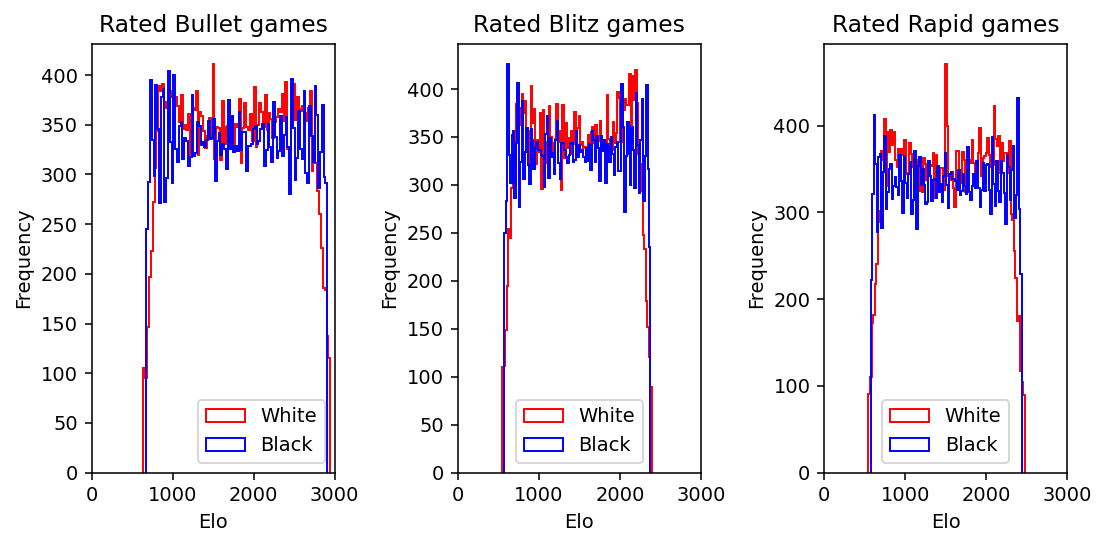

In [22]:
fig, axes = plt.subplots(1,3, figsize=(8,4), dpi=140)
histbins = 100
for i, ax in enumerate(axes.flatten()):
    edf = resampled_dfs[i]
    edf["WhiteElo"].plot.hist(ax=ax, bins=histbins, histtype="step", color="red", label="White")
    edf["BlackElo"].plot.hist(ax=ax, bins=histbins, histtype="step", color="blue", label="Black")
    ax.set_title(f"{events[i]}s")
    ax.set_xlabel("Elo")
    ax.set_xlim(0,3000)
    ax.legend()
fig.tight_layout()

In [23]:
pd.concat(resampled_dfs).shape

/Users/emmabingham/miniforge3/envs/chess/lib/python3.10/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding


(100080, 7)

In [24]:
pd.concat(resampled_dfs).groupby("Event").count() #["Termination"].value_counts()

,Site,WhiteElo,BlackElo,UTCDateTime,Termination,BlackEloBins
Event,,,,,,
Rated Blitz game,33360,33360,33360,33360,33360,33360
Rated Bullet game,33360,33360,33360,33360,33360,33360
Rated Rapid game,33360,33360,33360,33360,33360,33360


In [27]:
# get down to 100000 games (we overshot a bit) by randomly removing games
reduced_df = pd.concat(resampled_dfs).sample(n=100000, replace=False)

In [28]:
reduced_df["Event"].value_counts()

Event
Rated Rapid game     33335
Rated Blitz game     33334
Rated Bullet game    33331
Name: count, dtype: int64

In [295]:
# wrote the selected games to CSV (but without all columns)
# reduced_df.reset_index().drop(columns=["BlackEloBins"]).to_csv("/Volumes/Extreme SSD/chessdata/selected_games.csv")

# Read all columns and write the 100,000 games to CSV

In [29]:
reduced_df.head()

,Event,Site,WhiteElo,BlackElo,UTCDateTime,Termination,BlackEloBins
702180,Rated Rapid game,https://lichess.org/73XRCMCV,1844,1867,2024-05-17 14:55:52,Normal,"(1817.667, 1879.9]"
1173638,Rated Blitz game,https://lichess.org/Bn0OO1GR,728,594,2024-05-22 20:56:11,Time forfeit,"(570.195, 632.167]"
600911,Rated Rapid game,https://lichess.org/62Ne15NP,1348,1345,2024-07-24 22:25:57,Normal,"(1319.8, 1382.033]"
4303101,Rated Blitz game,https://lichess.org/hBFtrrCV,1675,1689,2024-10-01 21:05:41,Normal,"(1655.0, 1715.167]"
3579102,Rated Bullet game,https://lichess.org/ZvFKwlUn,2590,2720,2024-10-12 22:16:46,Normal,"(2685.7, 2760.133]"


In [30]:
# https://stackoverflow.com/questions/16568/how-to-select-the-nth-row-in-a-sql-database-table
# query = "SELECT * FROM games ORDER BY UTCDateTime, WhiteElo, BlackElo LIMIT 1,3122340"
# res = cur.execute(query)
# print("Rated Bullet games", res.fetchone())

In [43]:
sites_list = "'" + "', '".join(reduced_df['Site'].tolist()) + "'" # a string to put in the query

In [44]:
query = f"SELECT * FROM games WHERE Site in ({sites_list})"
full_resampled_df = pd.read_sql_query(query, con)
# print("Rated Bullet games", res.fetchone())

In [46]:
full_resampled_df.memory_usage()

Index                 128
id                 800000
Event              800000
Site               800000
Round              800000
White              800000
Black              800000
Result             800000
UTCDate            800000
UTCTime            800000
UTCDateTime        800000
WhiteElo           800000
BlackElo           800000
WhiteRatingDiff    800000
BlackRatingDiff    800000
WhiteTitle         800000
BlackTitle         800000
ECO                800000
Variant            800000
Opening            800000
TimeControl        800000
Termination        800000
Moves              800000
dtype: int64

In [48]:
full_resampled_df.head()

,id,Event,Site,Round,White,Black,Result,UTCDate,UTCTime,UTCDateTime,...,WhiteRatingDiff,BlackRatingDiff,WhiteTitle,BlackTitle,ECO,Variant,Opening,TimeControl,Termination,Moves
0,17,Rated Bullet game,https://lichess.org/KpaANKm3,-,scarface05,B0103232338,1-0,2024.01.01,00:00:58,2024-01-01 00:00:58,...,+6,-5,,,A40,,Queen's Pawn Game: Modern Defense,60+0,Normal,1. d4 { [%clk 0:01:00] } 1... g6 { [%clk 0:01:...
1,129,Rated Blitz game,https://lichess.org/ohPSu5HV,-,omarcolchon,yohoy,0-1,2024.01.01,00:14:53,2024-01-01 00:14:53,...,-5,+6,,,B20,,Sicilian Defense: Lasker-Dunne Attack,300+0,Normal,1. e4 { [%clk 0:05:00] } 1... c5 { [%clk 0:05:...
2,145,Rated Bullet game,https://lichess.org/hsZVDCXg,-,pw2007,cas579,0-1,2024.01.01,00:15:32,2024-01-01 00:15:32,...,-8,+6,,,C41,,Philidor Defense,60+0,Time forfeit,1. e4 { [%clk 0:01:00] } 1... d6 { [%clk 0:01:...
3,214,Rated Blitz game,https://lichess.org/nD5P3ERl,-,eshaughn88,jaxjacobs,0-1,2024.01.01,00:24:27,2024-01-01 00:24:27,...,-6,+6,,,C00,,French Defense: Knight Variation,300+0,Normal,1. e4 { [%eval 0.2] [%clk 0:05:00] } 1... e6 {...
4,220,Rated Rapid game,https://lichess.org/dMx2wqMt,-,Lebeux,Valentin140293,0-1,2024.01.01,00:24:58,2024-01-01 00:24:58,...,-5,+5,,,D00,,Queen's Pawn Game: Accelerated London System,600+0,Time forfeit,1. d4 { [%clk 0:10:00] } 1... d5 { [%clk 0:10:...


In [50]:
# full_resampled_df.to_csv("/Volumes/Extreme SSD/chessdata/resampled_100000_games.csv")